In [2]:
import requests

url = "https://i.redd.it/eicshce7piv81.jpg"
response = requests.get(url)

with open("image.jpg", "wb") as f:
  f.write(response.content)


In [9]:
%pip install git+https://github.com/huggingface/transformers.git
%pip install Pillow redvid
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-fkc7wl38
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-fkc7wl38
  Resolved https://github.com/huggingface/transformers.git to commit 2fc33ebead50383f7707b17f0e2a178d86347d10
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB ? eta 0:00:00 0:00:01m00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 47.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 35.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 47.0 MB/s eta 0:00:00:00:01

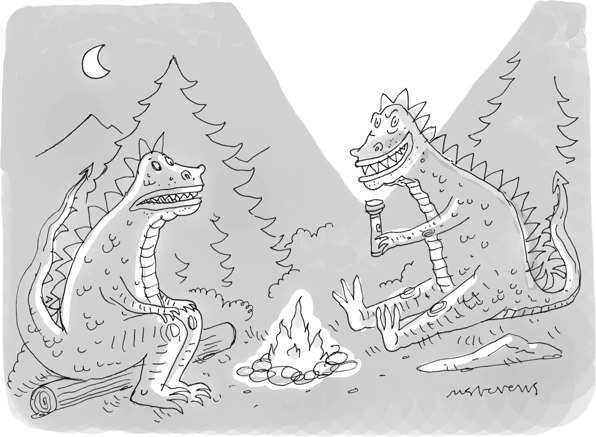

In [1]:
import requests
from PIL import Image

url = 'https://media.newyorker.com/cartoons/63dc6847be24a6a76d90eb99/master/w_1160,c_limit/230213_a26611_838.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')  
display(image.resize((596, 437)))

In [2]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)


/media/lettuce/Woo/reddit_scrape/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.01s/it]


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [5]:

def generate_blip2(image):
  inputs = processor(image, return_tensors="pt").to(device, torch.float16)
  generated_ids = model.generate(**inputs, max_new_tokens=20)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
  print(generated_text)


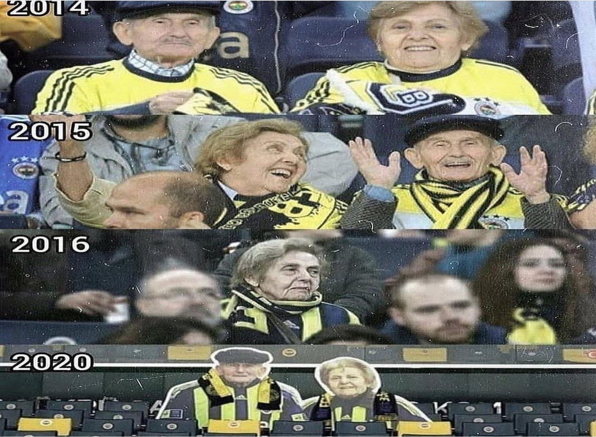

In [8]:
image = Image.open("image.jpg")
display(image.resize((596, 437)))



In [19]:
import requests
from redvid import Downloader

def downloadRedditVideo(url):
  reddit = Downloader(max_q=True)
  reddit.log = False
  reddit.url = url
  reddit.path = "./"
  reddit.filename = "video.mp4"
  reddit.download()
  print("Downloaded video.mp4")

In [9]:
generate_blip2(image)

a picture of people in a stadium with the same picture


In [25]:
import subprocess
from PIL import Image
def extractFrameFromVideo():
  input_file = 'video.mp4'
  output_file = 'video.jpg'

  #delete video.jpg if it exists
  subprocess.call(['rm', '-f', output_file])

  duration = float(subprocess.check_output(['ffprobe', '-i', input_file, '-show_entries', 'format=duration', '-v', 'quiet', '-of', 'csv=%s' % ("p=0")]).strip())
  middle_time = duration / 2
  #extract the frame
  subprocess.call(['ffmpeg', '-i', input_file, '-ss', str(middle_time), '-vframes', '1', '-q:v', '2', output_file], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
  print("Extracted frame from video.mp4")

  image = Image.open("video.jpg")
  return image


In [ ]:
url = "https://v.redd.it/ajz3tpajwcd91"
downloadRedditVideo(url)
image = extractFrameFromVideo()
display(image.resize((596, 437)))

In [6]:
import glob

json_files = glob.glob('./data/*.json')
print(json_files)

import json

def getRedditSubreddits(json_files):
  subreddits = {}
  for json_file in json_files:
    with open(json_file) as f:
      data = json.load(f)
      firstKey = next(iter(data))
      subredditName = data[firstKey]['subreddit']
      subreddits[subredditName] = data
  return subreddits

subreddits = getRedditSubreddits(json_files)

print(subreddits.keys())

['./data/facepalm_top_posts.json', './data/DunderMifflin_top_posts.json', './data/wholesomememes_top_posts.json', './data/science_top_posts.json', './data/BikiniBottomTwitter_top_posts.json', './data/freefolk_top_posts.json', './data/MadeMeSmile_top_posts.json', './data/StarWarsBattlefront_top_posts.json', './data/books_top_posts.json', './data/nextfuckinglevel_top_posts.json', './data/EarthPorn_top_posts.json', './data/AmItheAsshole_top_posts.json', './data/todayilearned_top_posts.json', './data/me_irl_top_posts.json', './data/WatchPeopleDieInside_top_posts.json', './data/thanosdidnothingwrong_top_posts.json', './data/Showerthoughts_top_posts.json', './data/Wellthatsucks_top_posts.json', './data/wallstreetbets_top_posts.json', './data/nottheonion_top_posts.json', './data/comics_top_posts.json', './data/awfuleverything_top_posts.json', './data/WhitePeopleTwitter_top_posts.json', './data/pics_top_posts.json', './data/IAmA_top_posts.json', './data/MemeEconomy_top_posts.json', './data/Leo

In [7]:
domains = set()
for subreddit in subreddits.values():
  for post in subreddit.values():
    try:
      domains.add(post['domain'])
    except:
      print(post)
      pass
print(domains)


{'talkingpointsmemo.com', 'foxnews.com', 'thedailybeast.com', 'pcgamesn.com', 'doi.org', 'washingtonpost.com', 'vulture.com', 'fox5dc.com', 'v.redd.it', 'eso.org', 'i.redd.it', 'cybernews.com', 'commondreams.org', 'flickr.com', 'newsweek.com', 'huffingtonpost.com', 'gamespot.com', 'cheatsheet.com', 'i.reddituploads.com', 'theguardian.com', 'self.IAmA', 'self.AskReddit', 'wgem.com', 'businessinsider.com', 'brokeassstuart.com', 'twitter.com', 'cnbc.com', 'static3.businessinsider.com', 'cbr.com', 'streamable.com', 'self.science', 'revolt.tv', 'npr.org', 'uawire.org', 'gfycat.com', 'cnn.com', 'timesofisrael.com', 'self.Showerthoughts', 'nytimes.com', 'self.gaming', 'edition.cnn.com', 'gizmodo.com', 'self.LifeProTips', 'mother.ly', 'en.wikipedia.org', 'theweek.com', 'battleforthenet.com', 'i.imgur.com', 'fortune.com', 'apnews.com', 'slantmagazine.com', 'news.avclub.com', 'psypost.org', 'kstp.com', 'google.com', 'self.movies', 'abc13.com', 'wwltv.com', 'self.videos', 'buzzfeednews.com', 'bbc

In [25]:
allowedDomains = ['i.redd.it', 'v.redd.it', 'i.imgur.com', 'youtu.be', 'youtube.com', 'i.reddituploads.com']
def filterSubreddits(subreddits):
  new_subreddits = {}
  deletedCount = 0
  domains = set()
  for subreddit_name, subreddit in subreddits.items():
    new_subreddit = {}
    for post_id, post in subreddit.items():
      #print(post['domain']
      
      if post['domain'] in allowedDomains or post['domain'].startswith('self.'):
        new_subreddit[post_id] = post
        domains.add(post['domain'])
      else:
        deletedCount += 1

    new_subreddits[subreddit_name] = new_subreddit
  print("Deleted", deletedCount, "posts")
  print(domains)
  return new_subreddits

subreddits= filterSubreddits(subreddits)


Deleted 0 posts
{'i.imgur.com', 'self.StarWarsBattlefront', 'self.science', 'self.politics', 'self.movies', 'self.thanosdidnothingwrong', 'v.redd.it', 'i.redd.it', 'self.videos', 'self.The-Jedi-Apprentice', 'self.Showerthoughts', 'self.wallstreetbets', 'self.gaming', 'self.LifeProTips', 'i.reddituploads.com', 'youtu.be', 'youtube.com', 'self.AmItheAsshole', 'self.books', 'self.IAmA', 'self.AskReddit'}


In [26]:
for subreddit_name, subreddit in subreddits.items():
  if len(subreddit) == 0:
    print(subreddit_name, "has zero posts")


todayilearned has zero posts
nottheonion has zero posts
worldnews has zero posts
news has zero posts
